<h1><center>WIMP relic density</center></h1>

In this problem sheet we will be solving the Boltzmann equation (Chapter 9.1) numerically and reproducing the typical WIMP abundance figures such as Figure 9.2 in the textbook (or similarly [here](https://www.researchgate.net/figure/Typical-evolution-of-the-WIMP-number-density-in-the-early-universe-during-the-epoch-of_fig1_46585999)).

In [1]:
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=18)

## 1) The equilibrium curve $Y_{eq}$

<ul>
<li>Assuming that the WIMP is always non-relativistic, write functions for the number density in equilibrium $n_{eq}$ and entropy $s$. To make things easier later, you should write the function such that they take x as an input parameter as well as any relevant constants.</li>

<li>Hence plot the equilibrium abundance $Y_{eq} = n_{eq}/s$ as a function of $x = m_{\chi}/T$</li>
</ul>

<i>Hint: Assume $g_{*s}(T)$ is a constant $g_{*s} = 90$.</i>

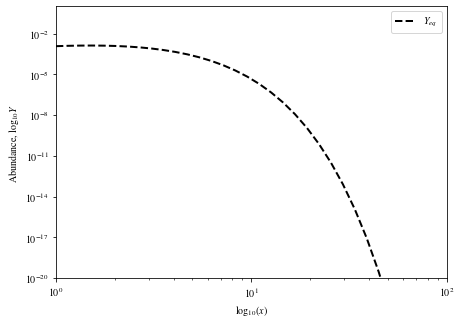

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def n_eq(x,m,g):
    const = (2*np.pi)**(-3/2)
    return const*g*m**3*x**(-3/2)*np.exp(-x)

def s(x, m):
    return 2*np.pi**2/45*gs*x**(-3)*m**3

def Y_eq(x, m, g):
    return n_eq(x,m,g)/s(x, m)


m = 100 # GeV
g_chi = 2
gs = 90

x = np.logspace(0, 3)
y_eq = Y_eq(x, m, g_chi)


# plot result
plt.figure(figsize = (7,5))
plt.loglog(x, y_eq,'k--', label = "$Y_{eq}$", lw = 2)
plt.ylabel("Abundance, $\log_{10}Y$");
plt.xlabel("$\log_{10}(x)$");
plt.ylim(1e-20, 1);
plt.xlim(1, 1e2);
plt.legend()

plt.show()

## 2) Solving equations numerically

A function can be solved numerically if we have an equation for it's derivative $dy/dx$ and some initial value $y_i$ using something like 

\begin{equation}
    y_{n+1} \approx y_{n} + \Delta x_n \frac{dy_n}{dx_n}.
\end{equation}

While a little more sophisticated, this is the basic principle of ODE solvers such as <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html">`scipy.integrate.odeint`</a>.
<ul>
<li>
As an example case, use `odeint` or otherwise to numerically solve the following:

\begin{equation}
    \frac{dy}{dx} = 9(x-4)^2 + 90\cos(3x)
\end{equation}

from the initial condition $(x_i, y_i) = (0,-192)$.
</li>
</ul>


<i>Hint: Examples and tutorial video given <a href = "https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations">here</a>.

-192.0


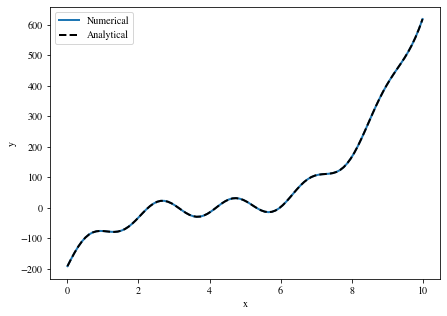

In [3]:
from scipy.integrate import odeint

def dydx(y, x):
    return 9*(x-4)**2 + 90*np.cos(3*x)

# replace this with odeint solution
y0 = -192
x = np.linspace(0, 10, int(1e2))
y_numerical = odeint(dydx, y0, x)

plt.figure(figsize = (7,5))
plt.plot(x, y_numerical, lw = 2, label = "Numerical")


#### Analytical solution ####
x = np.linspace(0, 10, 100)
y_analytical = 3*(x-4)**3 + 30*np.sin(3*x)
print(y_analytical[0])
plt.plot(x, y_analytical,'k--', lw = 2, label = "Analytical")

# plotting labels
plt.ylabel("y");
plt.xlabel("x");
plt.legend()

plt.show()

## 3) Solving the Boltzmann equation

Recall the Boltzmann equation:

\begin{equation}
    \frac{x}{Y_{eq}}\frac{dY}{dx} = \frac{-n_{eq}(T) \langle \sigma v \rangle}{H(T)} \Big[ \Big(\frac{Y}{Y_{eq}}\Big)^2-1\Big].
\end{equation}

Write another function for calculating the Hubble parameter $H$ as a function of temperature $T$.

While it is possible to use odeint to solve this equation directly, due to the large gradients it requires a large number of integration steps and is therefore very computationally expensive. One way we can get around this is to rewrite the equations in log space. 

<ul>
    <li>Using the Boltzmann equation above, calculate $\frac{d\log{Y}}{d\log{x}}$.</li>
    <li> Hence use `odeint` or otherwise to solve $\log{Y}$ numerically as done in the example case for $m_{\chi} = 100$ GeV, $\langle \sigma v \rangle = 10^{-12} $ GeV$^{-2}$ and $ \log(x) $ in the range $ \{0, 3\}$. You can assume that the cross section is independent of temperature.</li>
    <li>Plot the result on the same graph as $Y_{eq}$.</li>
</ul>

\begin{equation}
    \frac{d\log Y}{d\log x} = \frac{dY}{dx}\frac{x}{Y}
\end{equation}

*Hint: Since the our values vary on logarithmic scales, it is often easier solve our ODE with `odeint()` in log-space*

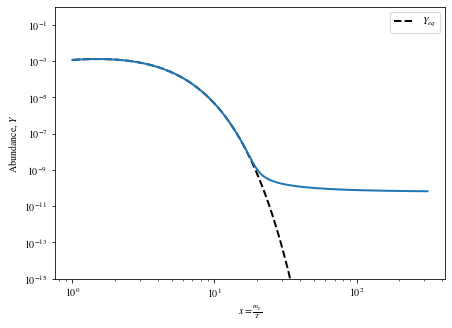

In [5]:
Mpl = 2.435e18 # GeV
def H(x, m):
    return np.sqrt(np.pi**2/90*gs)*(m/x)**2/(Mpl)

# Define the derivative functions such that it takes log(x) and log(Y) as functions
# this makes it easier for odeint to solve
def deriv(log_Y, log_x, m, sigv, g_chi):
    
    Y = 10**log_Y; x = 10**log_x
    
    y_eq = Y_eq(x, m, g_chi)
    
    dYdx = -n_eq(x, m, g_chi)*sigv/H(x, m)*((Y/y_eq)**2 - 1)*y_eq/x
    #print(log_x, log_Y, x, Y)
    out = dYdx * x / Y
    
    return out

# Define constants
m = 100 # GeV
sigv = 1e-10


log_x = np.linspace(0, 2.5, int(1e4))

# Plot Y_eq
x = 10**log_x

y_eq = Y_eq(x, m, g_chi)

plt.figure(figsize = (7,5))
plt.loglog(x, y_eq,'k--', label = "$Y_{eq}$", lw = 2)

# Calculate and plot Y

Y_eq0 = y_eq[0]
Y0 = [np.log10(Y_eq0)]

psoln = odeint(deriv, Y0[0], log_x, args = (m, sigv, g_chi))
Y = 10**psoln

plt.loglog(x, Y, lw = 2)

plt.ylim(1e-15, 1);
plt.xlabel(r"$x =\frac{m_{\chi}}{T}$");
plt.ylabel("Abundance, $Y$");
plt.legend();

## 4) $Y_{\infty}$ as a function of $\langle \sigma v \rangle$

<ul>
    <li>Repeat the above step for a few different values for the cross section in the range $\{10^{-12}, 10^{-8}\}$ GeV$^{-2}$ at a fixed WIMP mass.</li>
</ul>

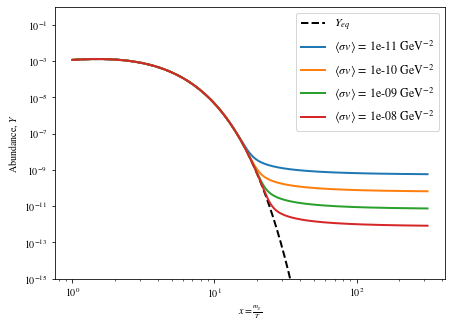

In [13]:
# Constants
m = 100 # GeV
g_chi = 2
g_s = 90

cross_sections = np.logspace(-11, -8, 4)

# Empty array to store Y_inf
Y_inf = np.empty(len(cross_sections))

log_x = np.linspace(0, 2.5, int(1e6))
x = 10**log_x

# Calculate and plot Y_eq 
y_eq = Y_eq(x, m, g_chi)

plt.figure(figsize = (7,5))
plt.loglog(x, y_eq,'k--', label = "$Y_{eq}$", lw = 2)
Y0 = np.log10(y_eq[0])

for i, sigv in enumerate(cross_sections):
    psoln = odeint(deriv, Y0, log_x, args = (m, sigv, g_chi))
    Y_i = 10**psoln
    plt.loglog(x, Y_i, lw = 2, 
               label = r"$\langle \sigma v \rangle$ = {:.3}".format(sigv) + " GeV$^{-2}$")
    Y_inf[i] = Y_i[-1][0]
    
plt.ylim(1e-15, 1);
plt.xlabel(r"$x =\frac{m_{\chi}}{T}$")
plt.ylabel("Abundance, $Y$")
plt.legend(loc = 1, prop={'size': 12})

plt.show()


<ul>
    <li>For each, extract the final value of $Y$. Hence make a plot of $Y_{\infty}$ against $\langle \sigma v \rangle$. Use <a href = "https://numpy.org/doc/1.18/reference/generated/numpy.polyfit.html">`numpy.polyfit`</a> to determine the relationship.</li>
    <li> How does this compare to our approximate solution from question 7 of problem sheet 5?</li>
</ul>
<i>Hint: We expect a power law profile.</i>

Y_(inf) ~ <sig v>^(-0.948)


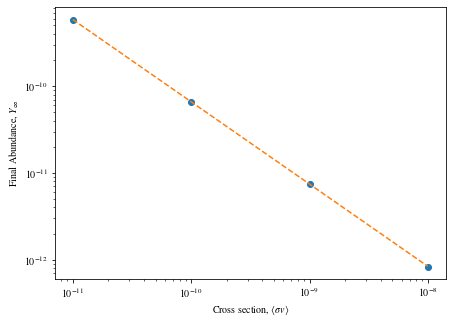

In [15]:
m, c = np.polyfit(np.log10(cross_sections), np.log10(Y_inf), deg = 1)

# Calculate power law and plot
plt.figure(figsize = (7,5))
# Plot data points
plt.loglog(cross_sections, Y_inf, 'o')
# Plot fitted lined
plt.loglog(cross_sections, 10**(m*np.log10(cross_sections)+c), '--')
plt.xlabel(r"Cross section, $\langle \sigma v \rangle$");
plt.ylabel("Final Abundance, $Y_{\infty}$");

# Print result
print("Y_(inf) ~ <sig v>^({:.3})".format(m))

## 5) $Y_{\infty}$ as a function of $m_{\chi}$

<ul>
    <li>Repeat the above step again but now for different values for the WIMP mass in the range $\{1, 10^{6}\}$ GeV.</li>
    <li>Make a plot of $Y_{\infty}$ against $M_{\chi}$. And determine the relationship using <a href = "https://numpy.org/doc/1.18/reference/generated/numpy.polyfit.html">`numpy.polyfit`</a>.</li>
    <li> How does this compare to our approximate solution from question 7 of problem sheet 5?</li>
</ul>
    
<i>Hint: We expect a power law profile.</i>

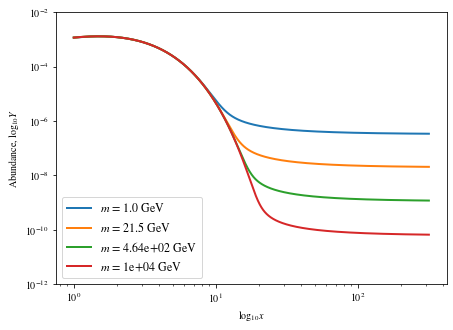

In [26]:
masses = np.logspace(0, 4, 4)
sigv = 1e-12

# Empty array to store Y_inf
Y_inf = np.empty(len(masses))

log_x = np.linspace(0, 2.5, int(1e5))
x = 10**log_x



plt.figure(figsize = (7,5))
# Calculate and plot Y_eq 
for i, m in enumerate(masses):
    y_eq = Y_eq(x, m, g_chi)
    #Y0 = np.log10(y_eq[0])
    psoln = odeint(deriv, Y0, log_x, args = (m, sigv, g_chi))
    Y_i = 10**psoln
    plt.loglog(x, Y_i, lw = 2, label = r"$m$ = {:.3}".format(m) + " GeV")
    Y_inf[i] = Y_i[-1]
    
plt.ylim(1e-12, 1e-2);
plt.xlabel("$\log_{10}x$")
plt.ylabel("Abundance, $\log_{10}Y$")
plt.legend(loc = 3, prop={'size': 12})

plt.show()

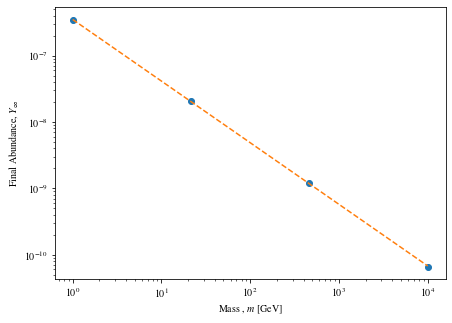

Y_(inf) ~ <sig v>^(-0.929)


In [28]:
# Calculate power law and plot 
Y_inf = np.asarray(Y_inf)
m, c = np.polyfit(np.log10(masses), np.log10(Y_inf), deg = 1)

plt.figure(figsize = (7,5))
plt.loglog(masses, Y_inf, 'o')
plt.loglog(masses, 10**(m*np.log10(masses)+c), '--')
plt.xlabel(r"Mass , $m$ [GeV]");
plt.ylabel("Final Abundance, $Y_{\infty}$");

plt.show()

# Print result
print("Y_(inf) ~ <sig v>^({:.3})".format(m))

## 7) Calculating the relic density $\Omega_{\chi}h^2$

In the lectures we saw that the relic density can be calculated from $Y_{\infty}$ via

\begin{equation}
    Y_{\infty} = \frac{45}{2\pi^2}\frac{\Omega_{\chi}h^2}{m_{\chi}}\frac{M_H^2M_{pl}^2}{T_0^3 g_{*s}(T_0)}
\end{equation}

<ul>
    <li>Use this along with your solver to calulate $\Omega_{\chi}h^2$ for a the ranges of masses and cross sections given above. That is, make a 2D array containing the relic density for each combination of mass and cross section.</li>
    <li>Plot the result using <a href = "https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.contourf.html">matplotlib.pyplot.contourf</a>. </li>
    <li>Add to your graph a single contour line indicating the values which give us the observed relic density of $\Omega_{DM}h^2 = 0.12$. An example of how to do this is included <a href="https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py">here</a>.</li>
    <li> How does this compare to our approximate solution from question 7 of problem sheet 5?</li>
</ul>


In [29]:
def Omega(Y_f, m_chi):
    T0 = 2.35e-13 # GeV
    M_H = 2.1e-42 # GeV

    A = 2*np.pi**2/45
    B = 1/(3*M_H**2*Mpl**2)
    C = T0**3.*gs
    
    return Y_f*m_chi*A*B*C

masses = np.logspace(0, 4, 30)
cross_sections = np.logspace(-10, -7, 30)

omega_chi = np.zeros((len(masses),len(cross_sections)))

g_chi = 2.0
g_s = 90.0

log_x = np.linspace(0, 2, int(1e4))

x = 10**log_x

failedm = []
failedsig = []

for i, m in enumerate(masses):
    y_eq = Y_eq(x, m, g_chi)
    Y0 = np.log10(y_eq[0])
    for j, sigv in enumerate(cross_sections):
        psoln = odeint(deriv, Y0, log_x, args = (m, sigv, g_chi),rtol=1e-10)
        Y_inf = 10**psoln[-1]
        if psoln[-1] > Y0:
            print('foo')
            log_x2 = np.linspace(0, 2, int(2e7))
            psoln = odeint(deriv, Y0, log_x2, args = (m, sigv, g_chi),rtol=1e-10)
            Y_inf = 10**psoln[-1]
        omega_chi[i,j] = Omega(Y_inf, m)

C:\Users\david\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


foo
foo


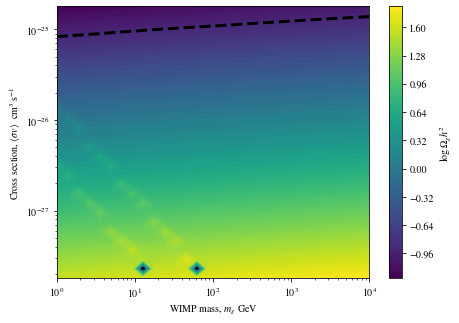

C:\Users\david\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: could not broadcast input array from shape (30,30) into shape (30,)

<Figure size 432x288 with 0 Axes>

In [30]:
#omega_chi[omega_chi>1e4] = 0

hbar = 2.58e-25 # GeV s
c = 3e10 # cm/s
cross_sections_cms = hbar**2*c**3*cross_sections

plt.figure(figsize = (7,5))
CS = plt.contourf(masses, cross_sections_cms, np.log10(omega_chi).T, 100)
cbar = plt.colorbar()
cbar.set_label('$\log{\Omega_{\chi}h^2}$')
plt.contour(CS, levels=[np.log10(0.12)], colors='k', linewidths = 3, linestyles = '--')
plt.xlabel(r"WIMP mass, $m_{\chi}$ GeV");
plt.ylabel(r"Cross section, $\langle \sigma v \rangle$  cm$^3$ s$^{-1}$");
plt.xscale("log")
plt.yscale("log")
plt.show()
plt.tight_layout()


save_path = r"/Users/david/Dropbox/dm-textbook/Figures/David/data/relic_density.npy"
np.save(save_path, [masses, cross_sections_cms, omega_chi.T])

## 8) $g_{*s}(T) \neq  const$

So far we have assumed that $g_{*s}(T) = const$. 

The number of relativistic degrees of freedom can be calculated numerically using lattice QCD. We can then make a interpolate the values at each temperature using a cubic spline. 

The following are values from <a href="https://arxiv.org/abs/1606.07494">Lattice QCD for Cosmology</a>. 

<table  style= "width:100%">
  <tr>
    <th>$\log_{10}{T}$ [MeV]</th>
    <td>0.0</td><td>0.5</td><td>1.0</td><td>1.25</td><td>1.6</td><td>2.0</td><td>2.15</td><td>2.2</td><td>2.4</td><td>2.5</td><td>3.0</td><td>4.0</td><td>4.3</td><td>4.6</td><td>5.0</td><td>5.45</td>
  </tr>
    
  <tr>
    <th>$g_{\rho}$</th>
    <td>10.71</td><td>10.74</td><td>10.76</td><td>11.09</td><td>13.68</td><td>17.61</td><td>24.07</td><td>29.84</td><td>47.83</td><td>53.04</td><td>73.48</td><td>83.1</td><td>85.56</td><td>91.97</td><td>102.17</td><td>104.98</td>
  </tr>
  <tr>
    <th>$\frac{g_{\rho}}{g_{*s}}$</th>
    <td>1.00228</td><td>1.00029</td><td>1.00048</td><td>1.00505</td><td>1.02159</td><td>1.02324</td><td>1.05423</td><td>1.07578</td><td>1.06118</td><td>1.0469</td><td>1.01778</td><td>1.00123</td><td>1.00389</td><td>1.00887</td><td>1.0075</td><td>1.00023</td>
  </tr>
</table>

Input these into <a href="https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d">`scipy.interpolate.interp1d`</a> to create a cubic spline.

<ul>
    <li> Use this to write a new function for $g_{*s}(T)$. </li>
    <li> Plot the interpolated value of $g_{*s}(T)$ along with the data points from the table. (Optional) include the values we would get if we chose to define $g_{*s}(T)$ as a step function (i.e. for T > 200 GeV: g_s = 106.75 etc... Nice summery <a href="https://physics.stackexchange.com/questions/169425/number-gt-of-relativistic-degrees-of-freedom-as-a-function-of-temperature-t">here</a>)</li>
    <li> Use this function to recalculate the above steps </li>
</ul>    

This functions will be used again when we calculate the axion relic density in the next lab sheet.

In [ ]:
from scipy.interpolate import interp1d

# Lattice QCD data
Tp = np.array([0.0, 0.50, 1.00, 1.25, 1.60, 2.00, 2.15, 2.2, 2.4, 2.5, 3.0 ,4.0, 4.3, 4.6,5,5.45])
gp = np.array([10.71,10.74,10.76,11.09,13.68,17.61,24.07,29.84,47.83,53.04,73.48,83.10,85.86,91.97,102.17,104.98])
gconv = np.array([1.00228,1.00029,1.00048,1.00505,1.02159,1.02324,1.05423,1.07575,1.06118,1.04690,1.01778,1.00123,1.00389,1.00887,1.00750,1.00023])
gs_val = gp/gconv

gs_int = interp1d(Tp, gs_val, kind = 'cubic', 
                  bounds_error=False, fill_value=(gs_val[0], gs_val[-1]))

gr_int = interp1d(Tp, gp, kind = 'cubic', 
                  bounds_error=False, fill_value=(gp[0], gp[-1]))

def gr(x, m):
    '''Takes temperature in GeV and returns number of relativistic degrees of
    freedom'''
    T = m/x
    return gr_int(np.log10(T*1e3))


def gs(x, m):
    '''Takes temperature in GeV and returns number of entropic degrees of
    freedom'''
    T = m/x
    return gs_int(np.log10(T*1e3))

m = 100
T = np.logspace(4, -5, 1000)
x = m/T

plt.figure(figsize = (7,5))
plt.semilogx(T, gs(x, m),lw=2, label="Spline")
plt.semilogx(10**(Tp)*1e-3, gs_val, 'ok', label="Data")
plt.xlim(max(T), min(T))

gs2 = [gs_crude(Ti) for Ti in T]

plt.semilogx(T, gs2,'--',lw=2, label = "Crude step\nfunction")
plt.ylabel("$g_{*}(T)$")
plt.xlabel("$T$ [GeV]")

plt.legend()